In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
indicators=pd.read_csv("RHoMISmother_indicators.csv")
codebook=pd.read_csv("raw data code book.csv")

In [3]:
raw=pd.read_csv("RHoMISmother_rawdata.csv",encoding = "ISO-8859-1")

C:\Users\Clare\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (7,8,29,46,48,49,58,65,70,77,80,84,97,119,121,122,123,124,125,126,127,129,133,134,136,137,139,141,142,145,146,147,149,150,153,155,158,164,166,171,173,249,270,285,294,301,316,319,330,334,337,348,355,366,370,373,377,378,379,381,382,383,384,385,386,387,388,390,392,393,394,395,396,397,399,400,401,402,403,404,405,406,408,410,411,412,413,414,415,417,418,419,420,421,422,423,424,426,428,429,430,443,444,456,462,469,475,499,500,514,515,517,519,525,531,535,536,538,539,541,542,555,556,561,565,569,570,571,573,575,576,581,587,591,592,594,595,597,598,611,612,614,615,617,619,621,625,626,627,629,631,632,637,639,640,642,644,645,647,648,650,651,653,654,655,656,658,660,664,665,667,668,669,670,671,674,675,689,691,693,694,703,704,706,707,709,710,719,723,724,726,727,728,729,730,735) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, r

In [4]:
# looking for duds in the HFIAS data
raw['HHid']=raw['HouseholdID']
HFIAS_data=pd.merge(raw[['HHid','HFIAS_1','HFIAS_2','HFIAS_3','HFIAS_4','HFIAS_5','HFIAS_6','HFIAS_7','HFIAS_8','HFIAS_9']],indicators[['HHid','HFIAS_status']],on='HHid')
HFIAS_most_null=[]
for i in range(len(HFIAS_data)):
    n=0
    for j in range(9):
        if pd.isnull( HFIAS_data.iloc[i,j+1] ):
            n+=1
    if n>=7:
        HFIAS_most_null.append(HFIAS_data.loc[i,'HHid'])

In [5]:
# failed attempts to drop null data
#for i in HFIAS_most_null:
#    (indicators[indicators['HHid']==i]['HFIAS_status'])

#hunger_HFIAS=hunger[:]
#for i in HFIAS_most_null:
#    hunger_HFIAS.drop('HHid'==i)
#hunger_HFIAS.set_index('HHid', inplace=True)
#hunger_HFIAS.drop(HFIAS_most_null,axis=0)
#hunger_HFIAS.reset_index(inplace=True)

#hunger_HFIAS=hunger[:]
#for i in range(len(hunger)):
#    if hunger.loc[i,'HHid'] in HFIAS_most_null:
#        hunger_HFIAS.drop(i,axis=0)
        



In [6]:
indicators.columns

Index(['HHid', 'Country', 'Region', 'Village', 'Latitude', 'Longitude',
       'HHsizemembers', 'HHsizeMAE', 'HouseholdType', 'Head_EducationLevel',
       'LandOwned', 'LandCultivated', 'LivestockHoldings', 'WorstFoodSecMonth',
       'BestFoodSecMonth', 'NrofMonthsFoodInsecure', 'score_PPI',
       'HFIAS_status', 'score_HDDSGoodSeason', 'HDDS_farmbasedGoodSeason',
       'HDDS_purchasedGoodSeason', 'score_HDDSBadSeason',
       'HDDS_farmbasedBadSeason', 'HDDS_purchasedBadSeason', 'total_income',
       'offfarm_income', 'farm_income', 'valuefarmproduce', 'cropsales',
       'valuecropproduce', 'valuecropconsumed', 'livestockprodsales',
       'valuelivestockproduction', 'valuelivestockprodconsumed',
       'FoodAvailability', 'FoodSelfSufficiency', 'TotalEnergyAvailable',
       'FAEnergyBought', 'FAEnergyOffFarm', 'FAEnergyCropConsumption',
       'FAEnergyCropSales', 'FAEnergyLivestockConsumption',
       'FAEnergyLivestockSales', 'FAEnergyFarmBased', 'FAMarketOrientation',
     

In [7]:
# create a numerical column for HFIAS status
# and this column will remove the really shit ones from the list of shit ones
# and a new column for income_percap
prob=0
for i in range(len(indicators)):
    if indicators.loc[i,'HHid'] in HFIAS_most_null:
        indicators.loc[i,'HFIAS_code']=None
    elif str(indicators.loc[i,'HFIAS_status'])=='FoodSecure':
        indicators.loc[i,'HFIAS_code']=0
    elif str(indicators.loc[i,'HFIAS_status'])=='MildlyFI':
        indicators.loc[i,'HFIAS_code']=1
    elif str(indicators.loc[i,'HFIAS_status'])=='ModeratelyFI':
        indicators.loc[i,'HFIAS_code']=2
    elif str(indicators.loc[i,'HFIAS_status'])=='SeverelyFI':
        indicators.loc[i,'HFIAS_code']=3
        continue
    else:
        prob+=1
zero=0
dz=0
for i in range(len(indicators)):
    if indicators.loc[(i,'HHsizeMAE')]!=0:
        indicators.loc[(i,'income_percap')]=np.divide(indicators.loc[(i,'total_income')],indicators.loc[(i,'HHsizeMAE')])
    else: 
        zero+=1
        if indicators.loc[(i,'HHsizemembers')]==0:
            dz+=1
            indicators.loc[(i,'income_percap')]=indicators.loc[(i,'total_income')]
        else:
            indicators.loc[(i,'income_percap')]=np.divide(indicators.loc[(i,'total_income')],indicators.loc[(i,'HHsizemembers')])
        
# make a new income percentile column
percentiles=np.zeros(10)
maps=np.arange(0,10,1)
for i in range(9):
    j=np.divide(i+1,10)
    percentiles[i+1]=indicators['income_percap'].quantile (q=j, interpolation='linear')
print(percentiles,maps)
indicators['inc_pc_perc']=None
for m in range(len(indicators)):
    k=9
    while indicators.loc[(m,'income_percap')]<percentiles[k]:
        k-=1
    indicators.loc[(m,'inc_pc_perc')]=maps[k]
indicators['inc_pc_perc']=pd.DataFrame(indicators['inc_pc_perc'],dtype='float')
print('There were problems in ',prob,' rows.')
print('There were ',zero,' households with no MAE. Of these, ',dz,' were recorded with no members at all.')

[  0.00000000e+00   1.84342857e-01   1.05003592e+01   2.58949485e+01
   5.14872286e+01   9.41080196e+01   1.56888886e+02   2.67285105e+02
   4.76762123e+02   1.09783781e+03] [0 1 2 3 4 5 6 7 8 9]
There were problems in  0  rows.
There were  36  households with no MAE. Of these,  15  were recorded with no members at all.


In [8]:
indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 57 columns):
HHid                            5000 non-null int64
Country                         5000 non-null object
Region                          4055 non-null object
Village                         4984 non-null float64
Latitude                        4788 non-null float64
Longitude                       4788 non-null float64
HHsizemembers                   5000 non-null int64
HHsizeMAE                       5000 non-null float64
HouseholdType                   4593 non-null object
Head_EducationLevel             4906 non-null object
LandOwned                       4432 non-null float64
LandCultivated                  5000 non-null float64
LivestockHoldings               5000 non-null float64
WorstFoodSecMonth               2379 non-null object
BestFoodSecMonth                2997 non-null object
NrofMonthsFoodInsecure          3764 non-null float64
score_PPI                       4479 no

In [9]:
hunger=indicators[['HHid','score_PPI','HFIAS_code','score_HDDSBadSeason','income_percap','inc_pc_perc','HDDS_farmbasedBadSeason','HDDS_purchasedBadSeason','CropDiv','LivestockDiv','FAEnergyOffFarm','FAEnergyFarmBased','FAMarketOrientation','NrofMonthsFoodInsecure','Country']]

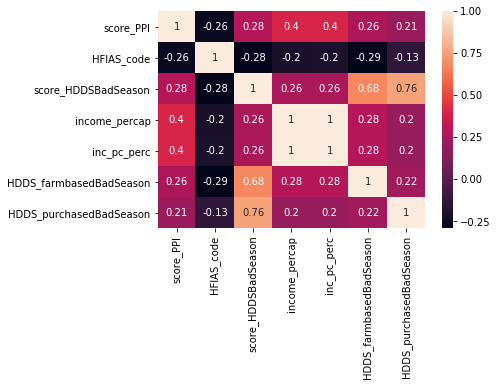

In [10]:
sns.heatmap(hunger[['score_PPI','HFIAS_code','score_HDDSBadSeason','income_percap','inc_pc_perc','HDDS_farmbasedBadSeason','HDDS_purchasedBadSeason']].corr(method='spearman'),annot=True)

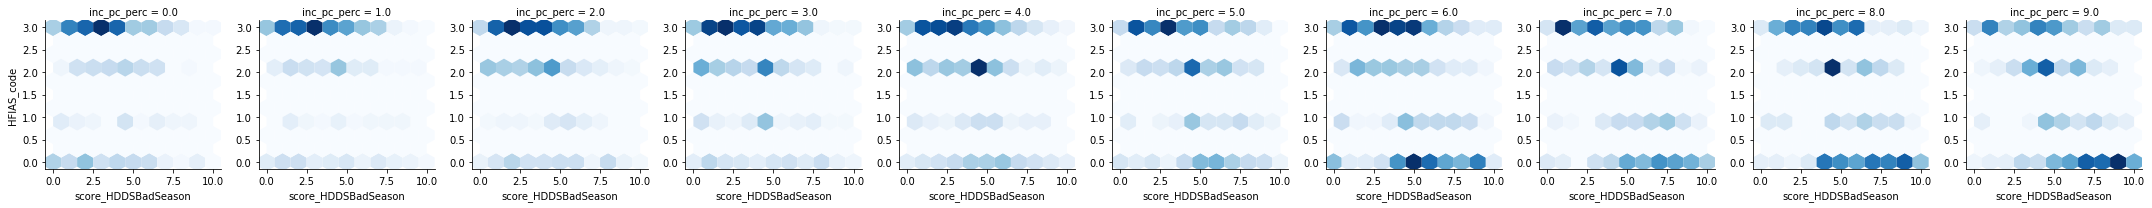

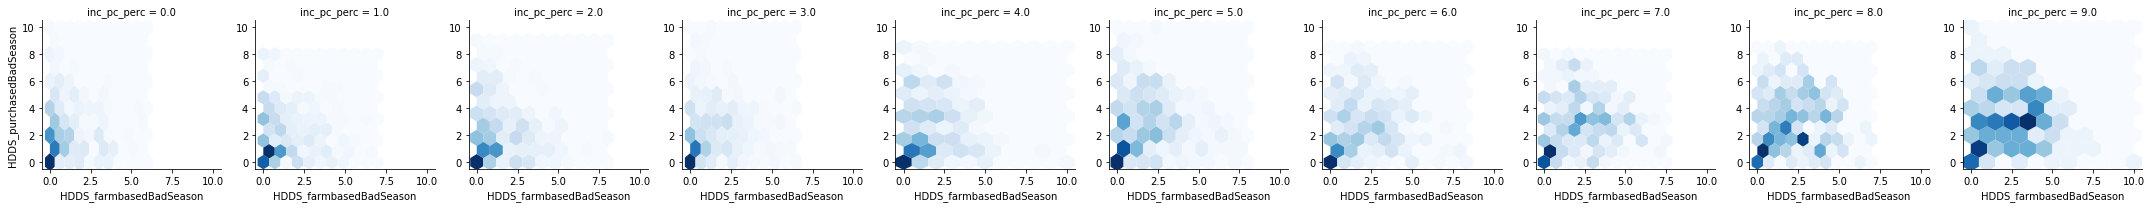

In [11]:
a= sns.FacetGrid(hunger,col='inc_pc_perc')
a.map(plt.hexbin,'score_HDDSBadSeason','HFIAS_code', gridsize=10,cmap='Blues', linewidth=0)
a.savefig('HDDS score and HFIAS code by income decile.png')

b= sns.FacetGrid(hunger,col='inc_pc_perc')
b.map(plt.hexbin,'HDDS_farmbasedBadSeason','HDDS_purchasedBadSeason',gridsize=10,cmap='Blues',linewidth=0)
b.savefig('HDDS farm based and purchased scores by income decile.png')

#for i in range(10):
#    data=hunger[hunger['inc_pc_perc']==i]
#    fig=plt.figure(figsize=(14,14))
#    a=fig.add_axes([0.1,0.1,0.9,0.8])
#    data.plot(x='score_HDDSBadSeason',y='HFIAS_code', ax=a, kind='hexbin', gridsize=10)
#    fig.savefig('income quantile '+str(i)+'.png')
#    plt.close()

# how much variation they get from the food they grow and the food they buy, by income
# richer people tend to both grow and buy better food
#for i in range(10):
#    data=hunger[hunger['inc_pc_perc']==i]
#    fig=plt.figure(figsize=(4,4))
#    a=fig.add_axes([0.1,0.1,0.9,0.8])
#    data.plot(x='HDDS_farmbasedBadSeason',y='HDDS_purchasedBadSeason', ax=a, kind='hexbin', gridsize=10)
#    a.set_title('income decile '+str(i))

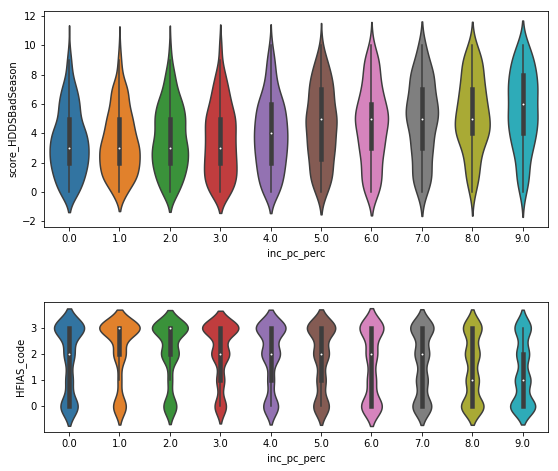

In [12]:
fig1=plt.figure(figsize=(7,3))
a1=fig1.add_axes([0,0.95,1,1])
a2=fig1.add_axes([0,0,1,0.6])
sns.violinplot(data=hunger, x='inc_pc_perc',y='HFIAS_code',ax=a2)
sns.violinplot(data=hunger, x='inc_pc_perc',y='score_HDDSBadSeason',ax=a1)
fig1.savefig('hunger and diet violins by income.png')
# people with more money are less hungry and eat a better variety of food in the bad season
# a significant proportion of the people with least money are not hungry

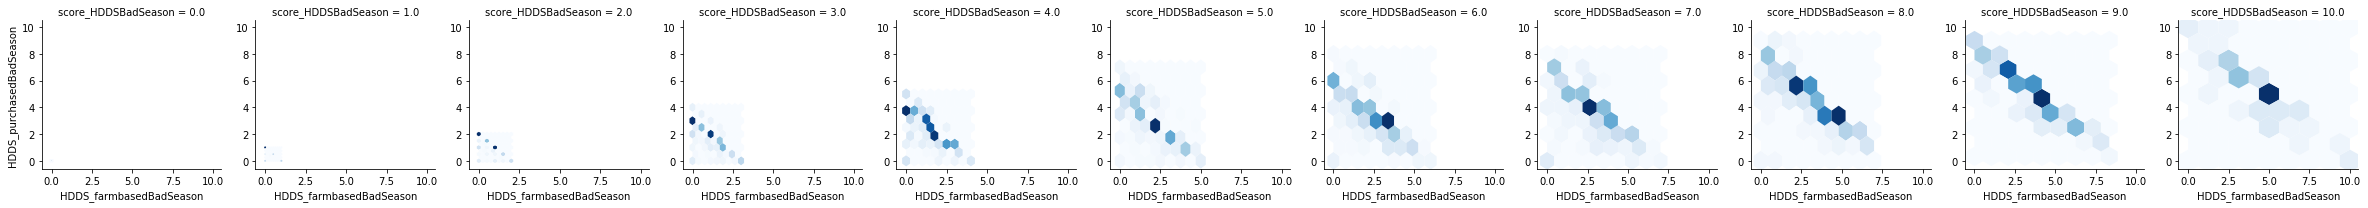

In [13]:
c= sns.FacetGrid(hunger,col='score_HDDSBadSeason')
c.map(plt.hexbin,'HDDS_farmbasedBadSeason','HDDS_purchasedBadSeason',gridsize=8,cmap='Blues', linewidth=0)
c.savefig('HDDS farmbased v purchased by HDDS.png')

# d= sns.FacetGrid(hunger,col='score_HDDSBadSeason')
# d.map(plt.hexbin,'HDDS_farmbasedBadSeason','HDDS_purchasedBadSeason','inc_pc_perc',gridsize=8,cmap='Blues', linewidth=0)
# d.savefig('HDDS farmbased v purchased by HDDS and income.png')


# people who have better food in the bad season normally get it from a mixture of their farm and from buying it
# for i in range(10):
#    data=hunger[hunger['score_HDDSBadSeason']==i]
#    fig=plt.figure()
#    a=fig.add_axes([0.1,0.1,0.9,0.8])
#    data.plot(x='HDDS_farmbasedBadSeason',y='HDDS_purchasedBadSeason', ax=a, kind='hexbin', xlim=(0,10),ylim=(0,10), gridsize=2+2*i)
#    a.set_title('HDDS bad season score '+str(i))


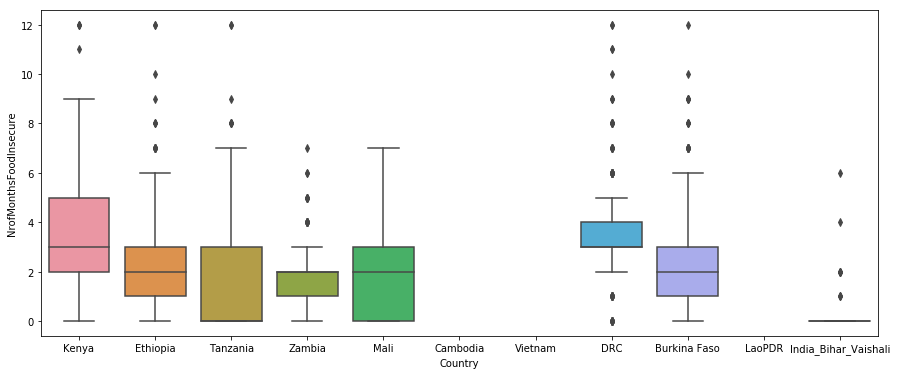

In [14]:
fig2=plt.figure(figsize=(15,6))
d=fig2.add_axes()
sns.boxplot(data=hunger,x='Country',y='NrofMonthsFoodInsecure', ax=d)
fig2.savefig('months food insecure by country.png')

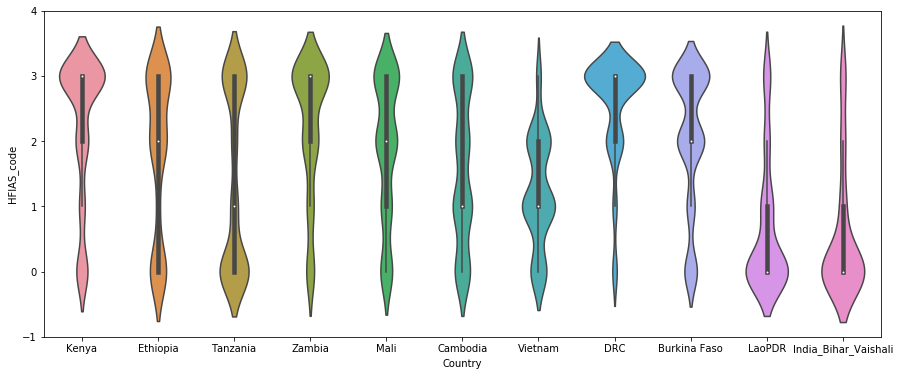

In [15]:
fig2=plt.figure(figsize=(15,6))
d=fig2.add_axes()
sns.violinplot(data=hunger,x='Country',y='HFIAS_code', ax=d)
fig2.savefig('HFIAS code by country.png')

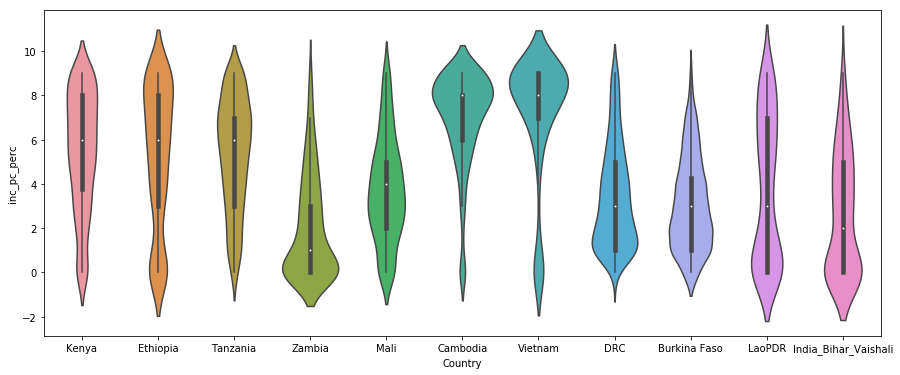

In [16]:
fig3=plt.figure(figsize=(15,6))
d=fig3.add_axes()
sns.violinplot(data=hunger,x='Country',y='inc_pc_perc', ax=d)
fig3.savefig('income per capita percentile by country.png')

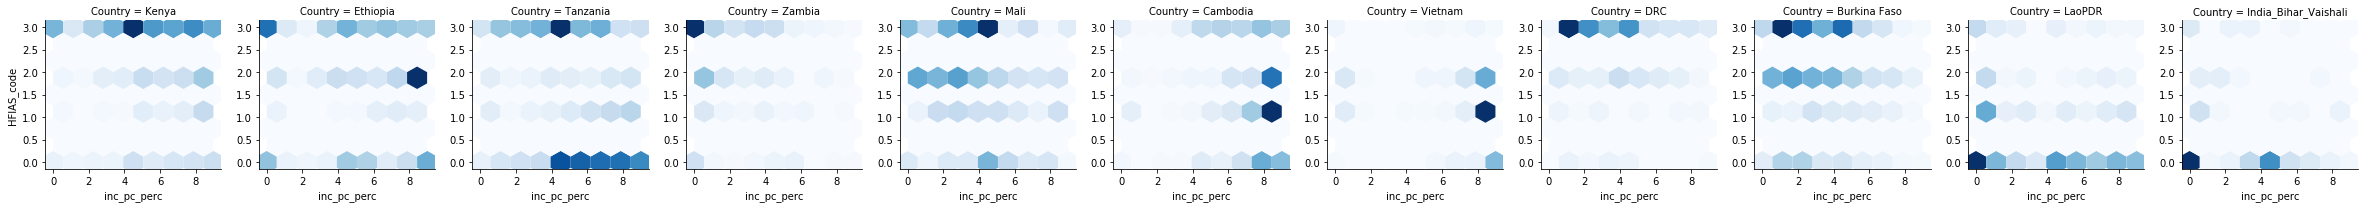

In [17]:
e= sns.FacetGrid(hunger,col='Country')
e.map(plt.hexbin,'inc_pc_perc','HFIAS_code',gridsize=8,cmap='Blues', linewidth=0)
e.savefig('Money and hunger by country.png')

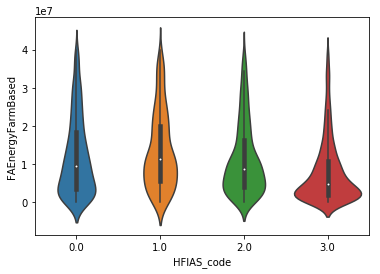

In [18]:
# the data is so skewed that it's difficult to make sense of as a scatter-type plot
# As violins, we see that the hungriest people tend to produce least food, 
# although also people with HFIAS code = 0 seem to produce little food.
# should explore missing data from the raw data, in particular data missing from the data used to calculate these indicators
sns.violinplot(data=hunger[hunger['FAEnergyFarmBased']<4e7],y='FAEnergyFarmBased',x='HFIAS_code')

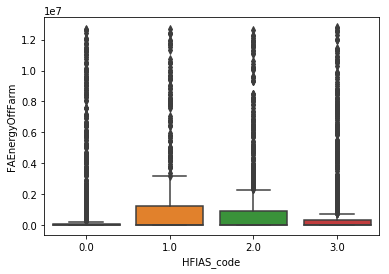

In [19]:
# Not a good representation really but better than the violin!
# Basically the FoodSecure people seem to be at 0
sns.boxplot(data=hunger[hunger['FAEnergyOffFarm']<1.28e7],y='FAEnergyOffFarm',x='HFIAS_code')

In [20]:
len(raw['region'].unique())

39

,score_HDDSBadSeason,CropDiv
score_HDDSBadSeason,1.00000,0.10061
CropDiv,0.10061,1.00000


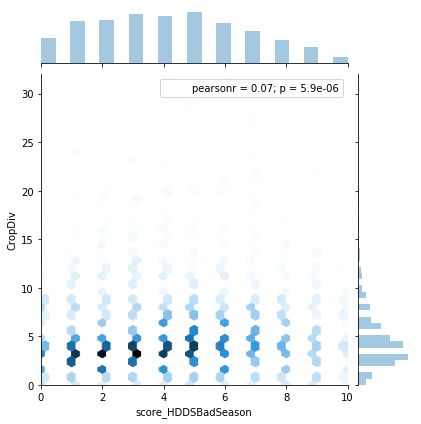

In [21]:
sns.jointplot(data=hunger, x='score_HDDSBadSeason', y='CropDiv', kind='hex')
# people who eat better year round tend to have slightly better crop diversity but this may not be statistically significant
hunger[['score_HDDSBadSeason','CropDiv']].corr(method='spearman')

,HFIAS_code,CropDiv
HFIAS_code,1.000000,-0.031861
CropDiv,-0.031861,1.000000


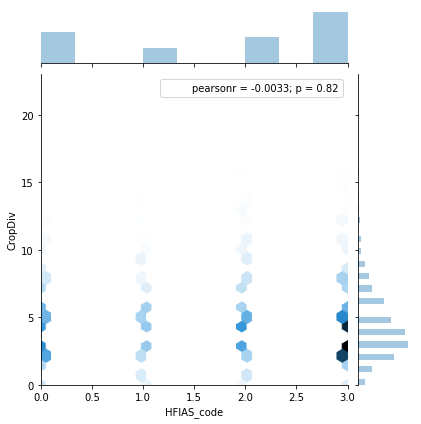

In [22]:
sns.jointplot(data=hunger, x='HFIAS_code', y='CropDiv', kind='hex')
# people who are most hungry seem to have more crop diversity ?? no correlation
hunger[['HFIAS_code','CropDiv']].corr(method='spearman')

,score_HDDSBadSeason,LivestockDiv
score_HDDSBadSeason,1.000000,0.057682
LivestockDiv,0.057682,1.000000


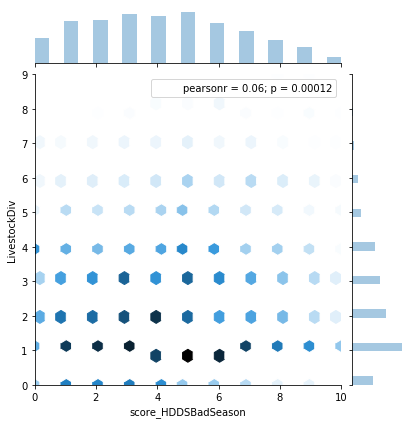

In [23]:
sns.jointplot(data=hunger, x='score_HDDSBadSeason', y='LivestockDiv', kind='hex')
# does not appear to be a relationship between diet in the bad season and livestock diversity
hunger[['score_HDDSBadSeason','LivestockDiv']].corr(method='spearman')

,HFIAS_code,LivestockDiv
HFIAS_code,1.000000,-0.059457
LivestockDiv,-0.059457,1.000000


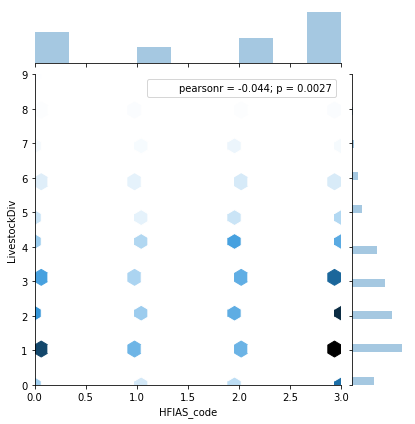

In [24]:
sns.jointplot(data=hunger, x='HFIAS_code', y='LivestockDiv', kind='hex')
# does not appear to be a relationship between hunger and livestock diversity
hunger[['HFIAS_code','LivestockDiv']].corr(method='spearman')

,FAEnergyFarmBased,FAMarketOrientation
FAEnergyFarmBased,1.000000,0.366448
FAMarketOrientation,0.366448,1.000000


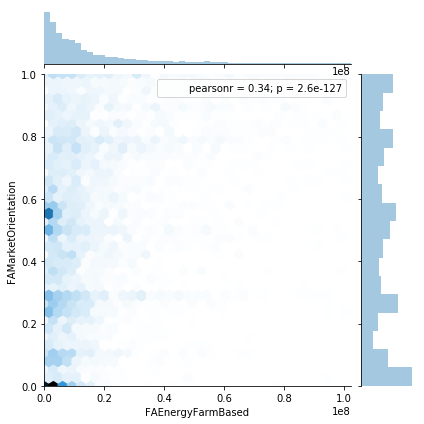

In [25]:
sns.jointplot(data=hunger[hunger['FAEnergyFarmBased']<102302868.29999973],x='FAEnergyFarmBased',y='FAMarketOrientation', kind='hex')
# it looks like people who produce more also buy more
# could well be that they have more money
hunger[['FAEnergyFarmBased','FAMarketOrientation']].corr(method='spearman')

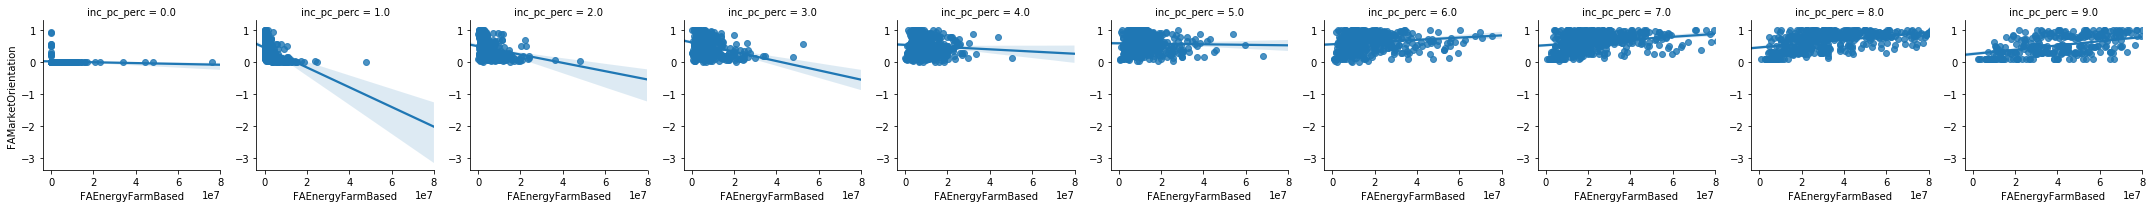

In [26]:
grid=sns.FacetGrid(hunger[hunger['FAEnergyFarmBased']<102302868.29999973],col='inc_pc_perc')
grid.map(sns.regplot, 'FAEnergyFarmBased','FAMarketOrientation')

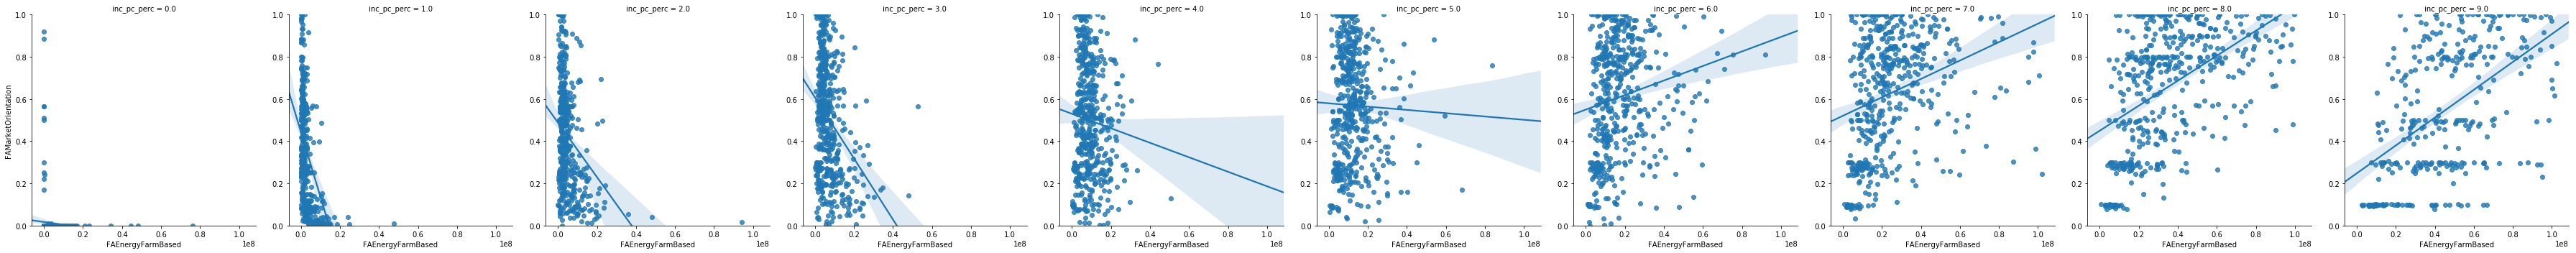

In [27]:
x=sns.lmplot('FAEnergyFarmBased','FAMarketOrientation',hunger[hunger['FAEnergyFarmBased']<102302868.29999973],col='inc_pc_perc', sharey=False)
x.set(ylim=(0,1))
#axes=x.axes
#axes[0,1].set_ylim(0,1)
x.fig.savefig('FAEnergy farmbased and market orientation by income')

In [28]:
indicators['FAEnergyFarmBased'].quantile (q=0.95, interpolation='linear')

102302868.29999973

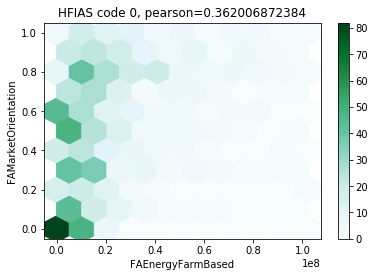

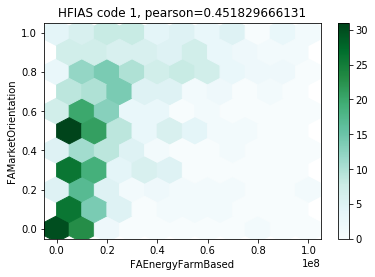

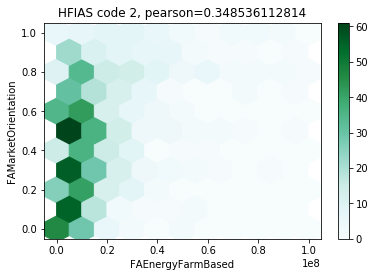

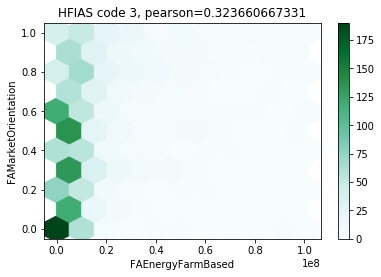

In [36]:
# looks like the hungriest people produce and buy less food
hunger2=hunger[hunger['FAEnergyFarmBased']<102302868.29999973]
hunger3=hunger2[hunger2['FAEnergyFarmBased']>0]

for i in range(4):
    fig=plt.figure()
    ax=fig.add_axes([0.1,0.15,0.8, 0.75])
    hunger3[hunger3['HFIAS_code']==i].plot(x='FAEnergyFarmBased',y='FAMarketOrientation', kind='hexbin', ax=ax, gridsize=10)
    ax.set_xlabel('FAEnergyFarmBased')
    r=hunger3[hunger3['HFIAS_code']==i].corr().iloc[11,12]
    ax.set_title('HFIAS code '+str(i)+', pearson='+str(r))
    fig.savefig('farm based energy and market orientation for HFIAS code '+str(i))

In [30]:
foodsec=hunger[indicators['HFIAS_code']==0]
foodsecpoor=foodsec[hunger['inc_pc_perc']==0]
foodsecpoor.describe()
# these people are very slightly less likely to live in poverty,
# more likely to have a bad diet in the bad season,
# grow about 1 fewer crops,
# have maybe half less livestock,
# produce less food on their farms,
# are much less market oriented,
# and at least half have no months of food insecurity compared to a global median of 2. Mean is 1.1 compared to 2.2

C:\Users\Clare\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,HHid,score_PPI,HFIAS_code,score_HDDSBadSeason,income_percap,inc_pc_perc,HDDS_farmbasedBadSeason,HDDS_purchasedBadSeason,CropDiv,LivestockDiv,FAEnergyOffFarm,FAEnergyFarmBased,FAMarketOrientation,NrofMonthsFoodInsecure
count,131.000000,131.000000,131.0,93.000000,131.000000,131.0,93.000000,93.000000,130.000000,131.000000,131.000000,1.310000e+02,111.000000,93.000000
mean,5205.725191,40.564885,0.0,3.247312,0.003321,0.0,0.872760,2.007168,2.884615,1.526718,13.931298,3.416121e+06,0.008415,1.086022
std,2184.910528,18.489955,0.0,2.434605,0.022073,0.0,1.142186,1.890881,2.243456,1.302827,159.450990,3.786802e+06,0.087405,1.571872
min,532.000000,5.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,3343.000000,26.000000,0.0,1.000000,0.000000,0.0,0.000000,0.500000,2.000000,0.000000,0.000000,3.481000e+05,0.000000,0.000000
50%,6588.000000,41.000000,0.0,3.000000,0.000000,0.0,0.500000,1.500000,3.000000,1.000000,0.000000,2.190000e+06,0.000000,0.000000
75%,7041.500000,53.000000,0.0,5.000000,0.000000,0.0,1.500000,3.000000,4.000000,2.000000,0.000000,5.365929e+06,0.000000,2.000000
max,7262.000000,96.000000,0.0,9.000000,0.173130,0.0,6.000000,9.000000,13.000000,6.000000,1825.000000,2.307135e+07,0.920931,7.000000


In [31]:
hunger.describe()


,HHid,score_PPI,HFIAS_code,score_HDDSBadSeason,income_percap,inc_pc_perc,HDDS_farmbasedBadSeason,HDDS_purchasedBadSeason,CropDiv,LivestockDiv,FAEnergyOffFarm,FAEnergyFarmBased,FAMarketOrientation,NrofMonthsFoodInsecure
count,5000.000000,4479.000000,4728.000000,4164.000000,4.999000e+03,5000.000000,3946.000000,3946.000000,4995.000000,4999.000000,4.999000e+03,4.999000e+03,4939.000000,3764.000000
mean,3960.027800,44.021433,1.772420,4.205572,3.513930e+03,4.501000,1.523864,2.420975,4.716917,2.269254,1.307176e+08,1.249179e+08,0.491370,2.244155
std,2287.033634,18.357791,1.226007,2.578391,1.381118e+05,2.873265,1.577403,1.939999,3.268940,1.672673,6.927207e+09,3.161148e+09,0.311485,2.040815
min,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1962.250000,31.000000,0.000000,2.000000,1.679606e+01,2.000000,0.000000,1.000000,3.000000,1.000000,0.000000e+00,3.327370e+06,0.245540,0.000000
50%,3969.500000,43.000000,2.000000,4.000000,9.410802e+01,5.000000,1.000000,2.000000,4.000000,2.000000,0.000000e+00,9.245263e+06,0.500000,2.000000
75%,5958.500000,56.000000,3.000000,6.000000,3.524198e+02,7.000000,2.500000,3.500000,6.000000,3.000000,1.859130e+06,2.274395e+07,0.767330,3.000000
max,7899.000000,100.000000,3.000000,10.000000,9.512821e+06,9.000000,10.000000,10.000000,32.000000,9.000000,4.846140e+11,2.076930e+11,1.000000,12.000000


In [32]:
# does not seem to be due to recording errors
for i in foodsecpoor['HHid']:
    print (raw[raw['HouseholdID']==i][['HFIAS_9','HFIAS_8','HFIAS_7','HFIAS_6','HFIAS_5','HFIAS_4','HFIAS_3','HFIAS_2','HFIAS_1']])

    HFIAS_9 HFIAS_8 HFIAS_7 HFIAS_6 HFIAS_5 HFIAS_4 HFIAS_3 HFIAS_2 HFIAS_1
322   never   never   never   never   never   never   never   never   never
    HFIAS_9 HFIAS_8 HFIAS_7 HFIAS_6 HFIAS_5 HFIAS_4 HFIAS_3 HFIAS_2 HFIAS_1
791   never   never   never   never   never   never   never   never   never
    HFIAS_9 HFIAS_8 HFIAS_7 HFIAS_6 HFIAS_5 HFIAS_4 HFIAS_3 HFIAS_2 HFIAS_1
825   never   never   never   never   never   never   never   never   never
    HFIAS_9 HFIAS_8 HFIAS_7 HFIAS_6 HFIAS_5 HFIAS_4 HFIAS_3 HFIAS_2 HFIAS_1
854   never   never   never   never   never   never   never   never   never
    HFIAS_9 HFIAS_8 HFIAS_7 HFIAS_6 HFIAS_5 HFIAS_4 HFIAS_3 HFIAS_2 HFIAS_1
856   never   never   never   never   never   never   never   never   never
    HFIAS_9 HFIAS_8 HFIAS_7 HFIAS_6 HFIAS_5 HFIAS_4 HFIAS_3 HFIAS_2  HFIAS_1
944   never   never   never   never   never   never   never   never  monthly
     HFIAS_9 HFIAS_8 HFIAS_7 HFIAS_6 HFIAS_5 HFIAS_4 HFIAS_3 HFIAS_2 HFIAS_1
1006   ne

     HFIAS_9 HFIAS_8 HFIAS_7      HFIAS_6      HFIAS_5 HFIAS_4 HFIAS_3  \
4267   never   never   never  fewpermonth  fewpermonth   never   never   

     HFIAS_2 HFIAS_1  
4267   never   never  
     HFIAS_9 HFIAS_8 HFIAS_7 HFIAS_6      HFIAS_5 HFIAS_4 HFIAS_3 HFIAS_2  \
4268   never   never   never   never  fewpermonth   never   never   never   

     HFIAS_1  
4268   never  
     HFIAS_9 HFIAS_8 HFIAS_7 HFIAS_6 HFIAS_5 HFIAS_4 HFIAS_3 HFIAS_2 HFIAS_1
4269   never   never   never   never   never   never   never   never   never
     HFIAS_9 HFIAS_8 HFIAS_7 HFIAS_6 HFIAS_5 HFIAS_4 HFIAS_3 HFIAS_2 HFIAS_1
4275   never   never   never   never   never   never   never   never   never
     HFIAS_9 HFIAS_8 HFIAS_7 HFIAS_6 HFIAS_5 HFIAS_4 HFIAS_3 HFIAS_2 HFIAS_1
4287   never   never   never   never   never   never   never   never   never
     HFIAS_9 HFIAS_8 HFIAS_7 HFIAS_6 HFIAS_5 HFIAS_4 HFIAS_3 HFIAS_2 HFIAS_1
4288   never   never   never   never   never   never   never   never   never
    

In [33]:
# they are not clustered by country
for i in foodsecpoor['HHid']:
    print (raw[raw['HouseholdID']==i][['country']])

    country
322   kenya
    country
791     tnz
    country
825     tnz
    country
854     tnz
    country
856     tnz
    country
944   kenya
     country
1006   kenya
     country
1011   kenya
     country
1056   kenya
     country
1142   kenya
     country
1149  zambia
     country
1212  zambia
     country
1221  zambia
     country
1226  zambia
     country
1247  zambia
     country
1248  zambia
     country
1266  zambia
     country
1324  zambia
     country
1354  zambia
     country
1355  zambia
     country
1356  zambia
     country
1361  zambia
     country
1363  zambia
     country
1364  zambia
       country
1834  tanzania
       country
1996  tanzania
       country
1999  tanzania
       country
2051  ethiopia
       country
2053  ethiopia
       country
2081  ethiopia
       country
2089  ethiopia
       country
2094  ethiopia
       country
2099  ethiopia
       country
2109  ethiopia
       country
2116  ethiopia
       country
2117  ethiopia
       country
2124  ethiopi